## Making the 4-panel plot of uncorrected SF

The 4-panel plot shows the problem :  how we can't get anything meaningful if we plot various characteristics of uncorrected data. Thus there is no reason to do splitting into magnitude bins, correcting, etc - it's not the purpose here. 

The desired magnitude range for the paper is 18.5-19 

In [40]:
import os
import numpy as np 
import matplotlib.pyplot as plt
import datetime
from astroML.stats import median_sigmaG
from scipy.stats import binned_statistic

from scipy.optimize import curve_fit

import CRTS_paper_modules as mod
import imp
imp.reload(mod)


<module 'CRTS_paper_modules' from '/Users/chris/GradResearch/CRTS_PROJECT/code/CRTS_paper_modules.py'>

In [2]:
from astropy.table import Table 


In [3]:
# Grab the two PTF-SDSS catalogs ...

# QSO 
address = '../data_products/PTF_SDSS_cross_matched_qso_DB9_catalog.dat'
qso_cat = Table.read(address,format='ascii' )

# stars 
address = '../data_products/PTF_SDSS_cross_matched_stars_catalog.dat'
star_cat = Table.read(address,format='ascii' )

In [49]:
qso_cat.colnames



['ra_sdss',
 'dec_sdss',
 'oid',
 'avg_err',
 'avg_mag',
 'mjd_span',
 'lc_length',
 'avg_day_mag',
 'proc_mjd_span',
 'avg_day_err',
 'avg_N_per_day',
 'proc_lc_length',
 'r',
 'M_i_corr',
 'mass_BH',
 'ra',
 'Lbol',
 'M_i',
 'z',
 'redshift',
 'Au',
 'u',
 'dec',
 'dbID',
 'SDR5ID',
 'i',
 'g',
 'match_radius_arcsec']

In [484]:
rcParams['ytick.labelsize'] = 20
rcParams['xtick.labelsize'] = 20
rcParams['axes.labelsize'] = 25
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 20

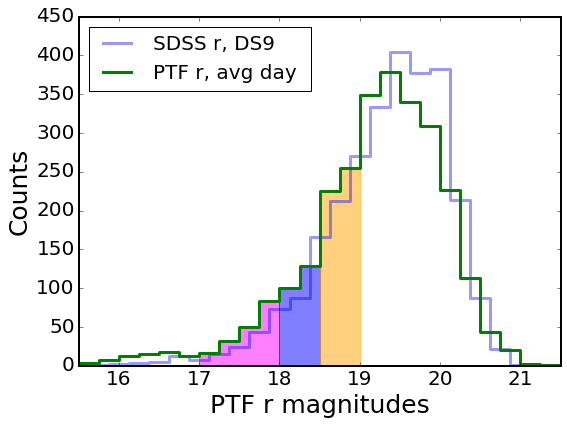

In [485]:
%matplotlib inline
x1 = 15.5
x2 = 22

fig,ax = plt.subplots(figsize=(8,6))

nbins=np.arange(15,22.2,0.25)
lw = 3 

m = (qso_cat['r'] > x1) * (qso_cat['r'] < x2)
#ax.hist(qso_cat['r'][m], histtype='step', label = 'SDSS r, DS9', bins=nbins)
hist, bin_edges = np.histogram(qso_cat['r'][m], bins=nbins, density=False)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
ax.plot(bin_centres, hist, ls='steps',  label='SDSS r, DS9', lw=lw, alpha=0.4)



m1 = (qso_cat['avg_mag'] > x1) * (qso_cat['avg_mag'] < x2) 
hist, bin_edges = np.histogram(qso_cat['avg_mag'][m1], bins=nbins, density=False)
bin_centres = (bin_edges[1:] + bin_edges[1:])/2
#ax.plot(bin_centres, hist, ls='steps',  label='PTF r, all epoch avg ', lw=lw, alpha=0.4)




m2 = (qso_cat['avg_day_mag'] > x1 ) * ( qso_cat['avg_day_mag'] < x2 )
hist, bin_edges = np.histogram(qso_cat['avg_day_mag'][m2], bins=nbins, density=False)
bin_centres = nbins[:-1] #(bin_edges[:-1] )
ax.plot(bin_centres, hist, ls='steps',  label='PTF r, avg day ', lw=lw)

# shade area under the used histogram population.... 
ax.fill_between(bin_centres, 0, hist, where = (bin_centres >= 16.8)*(bin_centres<=18), step='pre', 
                color='magenta', alpha=0.5 )

ax.fill_between(bin_centres, 0, hist, where = (bin_centres >= 17.9)*(bin_centres<=18.55), step='pre', 
                color='blue', alpha=0.5 )

ax.fill_between(bin_centres, 0, hist, where = (bin_centres >= 18.35)*(bin_centres<=19.1), step='pre', 
                color='orange', alpha=0.5 )

# the bin edges do not exactly align with sample boundaries... ignore that in my simple illustration...
#m = ((bin_centres - 17) > 0 ) * ((bin_centres - 17) < 0.15)
#ax.fill_between(x=[17, bin_centres[m][0]], y1=[0,0], y2 =  [hist[m][0], hist[m][0]],color='magenta', alpha=0.5 )

#for x in [17,18,18.5,19] : 
#    ax.axvline(x, ymax=0.5,ls='--')
ax.set_xlabel('PTF r magnitudes') # , fontsize=20 
ax.set_ylabel('Counts') # , fontsize=20 

ax.set_xlim(15.5,21.5)
ticks = ax.get_xticks()
ax.set_xticks(ticks[1:-1])

plt.legend(loc='upper left', fontsize=20 )   
#plt.title('Quasar population: magnitude selection', fontsize=15)
plt.tight_layout()
plt.savefig(outDir + 'Fig_2_Quasar_PTF_population_selection.png')
#ax.set_xlim(16.5,18.5)
#ax.set_ylim(0,50)
#ax.fill_between?


In [243]:
Min = 18.5
Max = 19.0
magnitudes = ['r']  # don't need g magnitude , decided to use only r magnitude 

objects_in_cut = {}

for mag in magnitudes : 
    cut_mag = mag
    report_mag = mag
    
    print('\nUsing now only lightcurves with SDSS  %f< %s < %f' % (Min, cut_mag, Max))
    print('\n Reporting SDSS %s  '% report_mag)

    good_ids_S_blue = mod.cut_stars(star_cat = star_cat,mMin = Min, mMax=Max, mErrMax = 0.3, gi_Min = -1,
                                              gi_Max=1, cut_mag=cut_mag + '_mMed', survey='PTF')
    
    good_ids_S_red = mod.cut_stars(star_cat = star_cat,mMin = Min, mMax=Max, mErrMax = 0.3, gi_Min = 1, 
                                           gi_Max=3, cut_mag=cut_mag + '_mMed', survey='PTF')
    
    good_ids_QSO = mod.cut_qso(qso_cat=qso_cat, mMin = Min, mMax=Max, mErrMax = 0.3, 
                                               cut_mag=cut_mag, survey='PTF')
    objects_in_cut[mag] = {'starsB':good_ids_S_blue, 'starsR':good_ids_S_red, 
                           'qso':good_ids_QSO}
    


Using now only lightcurves with SDSS  18.500000< r < 19.000000

 Reporting SDSS r  

Choosing stars with  SDSS   -1.00<g-i<1.00
 These cuts reduced the number of stars  in the sample from 15714 to 548

Choosing stars with  SDSS   1.00<g-i<3.00
 These cuts reduced the number of stars  in the sample from 15714 to 913

 Returning only QSO with  an SDSS counterpart within 2.000000 arcsec

 These cuts reduced the number of qso  in the sample from 2753 to 377


In [244]:
bins = {}
bin_types = ['r_cut']  # removed 'g_cut'

objects = objects_in_cut['r'].keys()

# first need to explicitly initialize the dictionaries 
for b in bin_types:
    bins[b] = {}
    
for obj in objects : 
    bins['r_cut'][obj] =  objects_in_cut['r'][obj]

## Read the xi, ei for objects in the r_cut ... 

In [234]:
imp.reload(mod)

<module 'CRTS_paper_modules' from '/Users/chris/GradResearch/CRTS_PROJECT/code/CRTS_paper_modules.py'>

In [245]:
inDirStars   = '../data_products/sf_file_per_LC_PTF/stars/'
inDirQSO = '../data_products/sf_file_per_LC_PTF/qso/'

out_dic = {}

#for b in bins.keys():
# read in only r_cut 

b = 'r_cut'
print('Reading in xi, ei for bin %s'% b)
out_dic[b] = {}   # initialize the dic 

good_ids_S_blue = bins[b]['starsB']
good_ids_S_red = bins[b]['starsR']
good_ids_QSO = bins[b]['qso']

qso, starB, starR = mod.read_xi_ei(inDirStars, good_ids_S_blue,  inDirQSO,
                                   good_ids_QSO, good_ids_S_red)

# put into a dictionary : makes it more explicit 
out_dic[b] = {'starsB': starB, 'starsR': starR, 'qso':qso}


# Straight after reading-in xi, ei,   one can proceed directly to part 9) (one bin) or 10 : all bins sigma comparison 
# or to Saving just the log(tau) samples of xi, tau, ei. 


Reading in xi, ei for bin r_cut
making new delflx, tau, xi arrays


Reading in quasars...
Returning delta_time in observed frame, t_obs
[######### ] 99.47%

Reading in blue stars ...
[######### ] 99.45%

Reading in red stars ...
[######### ] 99.67%

## Calculate SF, mu in approximate and  full  ways

In [246]:
# for all imports of my functions, 
# make python aware of my packages...
import sys
sys.path.insert(0, '../../SDSS_S82_FP_research/packages/')
import variabilityFunctions as varF


In [247]:
os.getcwd()[:-4]

'/Users/chris/GradResearch/CRTS_PROJECT/'

The thing below takes a while (up to half hour...) because calculating $\mu$, $\sigma$ based on full posterior PDF is pretty slow ... 

In [248]:
# Run the calculation over all bins : 
# - keep the option to plot a bin if one wants to compare the three methods : need to provide object N
#   
# - as it is, calculate three values for sigma, etc., and plot it  

# Set the bin  : here we use only r_cut 
b = 'r_cut'

# set the bin number 
nbins = 200 

# set the m_ij cutoff 
m_ij_cutoff = 1.0

# Set a directory to save the results...
outDir = os.path.join(os.getcwd()[:-4]+'data_products/'+'PTF_Fig_2_data/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
                      
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'PTF_Fig_2_data', 
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
                      
print('Today we will save our Fig_2 files in %s'%outDir)

# Loop over objects in the dictionary  
for obj in out_dic[b].keys(): 
    print('\n For obj = %s'% obj)
    # obj = 'qso'  # or starsB,  starsR 
    
    m_ij = out_dic[b][obj][0]
    tau =  out_dic[b][obj][1]
    e_ij = out_dic[b][obj][2]
    
    # do that and see what happens ... 
    mask_out = abs(m_ij)<m_ij_cutoff
    m_ij = m_ij[mask_out]
    tau = tau[mask_out]
    e_ij = e_ij[mask_out]
    
    #n =  out_dic[b][obj][3]

    # Pull out some tau to plot means : common to all panels 
    binned_tau = binned_statistic(tau, tau, statistic='mean', bins=nbins)
    mean_tau = binned_tau[0]
    
    # Take N from each bin... 'count' function works like a regular histogram
    binned_count = binned_statistic(tau, tau, statistic='count', bins=nbins)
    bin_count = binned_count[0]
    #bin_names = np.arange(1,len(binned_count[2]))

    # Calculate median preprocessed photometric error per bin 
    binned_err_median = binned_statistic(tau, e_ij, statistic='median', bins=nbins) 
    err_median = binned_err_median[0]

    # make sure that there are no empty bins : such calculation would be truly obsolete... 
    non_empty_bins = np.bitwise_not(np.isnan(mean_tau))

    # reassign number of points in a bin and  tau position 
    bin_count = bin_count[non_empty_bins]
    mean_tau = mean_tau[non_empty_bins]
    err_median = err_median[non_empty_bins]

    # A long list telling which point belongs to which bin
    bin_number  = binned_tau[2]
    
    ####
    ####  Panel 1 : Standard Deviation 
    ####

    rms_std = lambda x : np.std(x)
    stdev_binned = binned_statistic(tau, m_ij, statistic = rms_std, 
                                              bins=nbins)
    bin_stdev = stdev_binned[0][non_empty_bins]  

    #####
    ##### Panel 2  : Gaussian rms  
    #####
    rms_robust = lambda x : 0.7414 *(np.percentile(x,75) - np.percentile(x,25))
    bin_sigma_G = binned_statistic(tau, m_ij, statistic = rms_robust, 
                                      bins=nbins)[0][non_empty_bins]

    #####
    ##### Panel 3 (SF)   and Panel 4   (mu)
    #####


    # Loop over all bins  calculating approximate mu and sigma 

    mu_bins = {}
    sig_bins = {}
    #nbins = len(bin_count)

    sig_bins['approx'] = np.zeros(nbins)
    mu_bins['approx'] = np.zeros(nbins)
    sig_bins['full'] = np.zeros(nbins)
    mu_bins['full'] = np.zeros(nbins)
    
    for N in np.unique(bin_number):
        print('\r --- Calculating mu, sigma for bin %d' % N),
        xi = m_ij[bin_number == N]
        ei = e_ij[bin_number == N]
        print('N_points = %d'%len(xi))
   
        mu_approx, sig_approx = varF.approximate_mu_sigma(xi, ei)
        mu_full, sig_full =  varF.get_mu_sigma(xi,ei)
        
        sig_bins['approx'][N-1] = sig_approx
        sig_bins['full'][N-1] = sig_full
        
        mu_bins['approx'][N-1] = mu_approx
        mu_bins['full'][N-1] = mu_full 

    # select only those bins which are non-zero...
    for key in ['approx','full']:
        sig_bins[key] = sig_bins[key][non_empty_bins]
        mu_bins[key] = mu_bins[key][non_empty_bins]
    
    # Save the results of calculation  : Panel 1,2,3,4 
    fname = outDir+ b+'_'+str(Min)+'-'+str(Max)+'_'+obj+'_mij_lt_'+str(m_ij_cutoff)+'.txt'
    
    data = np.column_stack((mean_tau, bin_stdev, bin_sigma_G, sig_bins['full'], 
                            sig_bins['approx'], mu_bins['full'], mu_bins['approx'], bin_count))

    header = 'meanTau   stdev    sigmaG   sigmaFull  sigmaApprox   muFull  muApprox   binCount'
    np.savetxt(fname, data, fmt = '%s', delimiter = ' ' , header=header )
    print('Results saved as %s' % fname)

print('Done with calculating panel data ')

Today we will save our Fig_2 files in /Users/chris/GradResearch/CRTS_PROJECT/data_products/PTF_Fig_2_data/2017-01-20/

 For obj = starsR
 --- Calculating mu, sigma for bin 1
N_points = 52807
 --- Calculating mu, sigma for bin 2
N_points = 29358
 --- Calculating mu, sigma for bin 3
N_points = 24048
 --- Calculating mu, sigma for bin 4
N_points = 18391
 --- Calculating mu, sigma for bin 5
N_points = 15025
 --- Calculating mu, sigma for bin 6
N_points = 15292
 --- Calculating mu, sigma for bin 7
N_points = 11688
 --- Calculating mu, sigma for bin 8
N_points = 8471
 --- Calculating mu, sigma for bin 9
N_points = 6644
mu at the last grid point
 --- Calculating mu, sigma for bin 10
N_points = 5340
mu at the last grid point
 --- Calculating mu, sigma for bin 11
N_points = 6919
 --- Calculating mu, sigma for bin 12
N_points = 5408
 --- Calculating mu, sigma for bin 13
N_points = 3871
mu at the last grid point
 --- Calculating mu, sigma for bin 14
N_points = 2598
 --- Calculating mu, sigma for 

Plot below the raw $\Delta m_{ij}$ for quasars, applying my mask. 

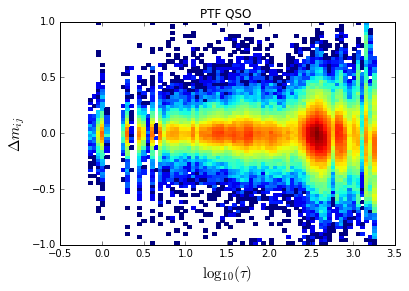

In [249]:
obj = 'qso'
m_ij_cutoff = 1.0

m_ij = out_dic[b][obj][0]
tau =  out_dic[b][obj][1]
e_ij = out_dic[b][obj][2]


rms_std = lambda x : np.std(x)
stdev_binned = binned_statistic(tau, m_ij, statistic = rms_std, 
                                      bins=nbins)
bin_stdev = stdev_binned[0][non_empty_bins]

# some m_ij seems completely unphysical... seems that there may be some 'outlier' points in lightcurves 
# that are completely off the scale, and maybe should be discarded at earlier  stage ... 

# makes sense that if there is one outlier point, then all magnitude differences calculated from 
# that point will be offset as much as that point 

m=abs(m_ij)<m_ij_cutoff
H, xedges, yedges = np.histogram2d(np.log10(tau[m]), m_ij[m], bins=70)
H = np.rot90(H)
H = np.flipud(H)
# Mask zeros
Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zeropltssssss
# Plot 2D histogram using pcolor
plt.pcolormesh(xedges,yedges,np.log10(Hmasked), cmap='jet')
plt.xlabel(r'$\log_{10}(\tau)$', fontsize=15)
plt.ylabel(r'$\Delta m_{ij}$',fontsize=15)
plt.title('PTF QSO ')
plt.savefig(outDir+'Fig_2_'+str(Min)+'-'+str(Max)+'_raw_data.png')

In [250]:
# NUMPY SAVE  :  A FANTASTIC  MOVE ! 
savefile = outDir+'r_cut_'+str(Min)+'-'+str(Max)+'_all_obj_out_dic'
np.save(savefile, out_dic)

In [252]:
#Demonstrate loading 
load_npy = np.load(savefile+'.npy')

In [253]:
# Recover the dictionary  
# completely unparalleled move : 
# http://stackoverflow.com/questions/30811918/saving-dictionary-of-numpy-arrays 
load_dic = load_npy[()]['r_cut']

In [406]:
load_dic

{'qso': (array([ 0.0621,  0.0723, -0.0443, ...,  0.0227, -0.0202,  0.    ]),
  array([  0.9181,   0.9189,   0.943 , ...,  52.9368,  53.8984,  54.8926]),
  array([ 0.06019909,  0.06090156,  0.04957953, ...,  0.08033891,
          0.0585691 ,  0.0545067 ]),
  array(['1.148971', '1.148971', '1.148971', ..., '9.871655', '9.871655',
         '9.871655'], 
        dtype='<U10')),
 'starsB': (array([ 0.1782,  0.1335, -0.0505, ...,  0.0141, -0.1048,  0.0413]),
  array([  8.65100000e-01,   9.18100000e-01,   9.18900000e-01, ...,
           1.08904800e+03,   1.09103100e+03,   1.09302730e+03]),
  array([ 0.09134993,  0.06329423,  0.06329423, ...,  0.03539901,
          0.16038984,  0.03507207]),
  array(['0.503475', '0.503475', '0.503475', ..., '9.865099', '9.865099',
         '9.865099'], 
        dtype='<U10')),
 'starsR': (array([ 0.2328, -0.233 , -0.0209, ...,  0.0573,  0.0689,  0.0055]),
  array([   0.8651,    0.8817,    0.9429, ...,  436.8747,  440.8423,
          442.8748]),
  array([ 0.202

## Figure out how many points are removed by cutting off outliers... 

To be able to say that we have enough  magnitude-difference points to split them into 200 bins, and that removing the outliers  that are off by more than +/- 1 mag from 0 does not make much difference in the number of points used , but it does make the SF (variance measure) much more informative. 

In [409]:
Min_arr = [17,18,18.5]
Max_arr = [18, 18.5, 19.0]

all_dic = {17:{},18:{},18.5:{}}

for i in range(3):
    Min = Min_arr[i]
    Max = Max_arr[i]
    savefile = outDir+'r_cut_'+str(Min)+'-'+str(Max)+'_all_obj_out_dic.npy'
    print('Loading %s '%savefile)
    load_npy = np.load(savefile)
    load_dic = load_npy[()]['r_cut']
    all_dic[Min] = load_dic

Loading /Users/chris/GradResearch/CRTS_PROJECT/data_products/PTF_Fig_2_data/2017-01-20/r_cut_17-18_all_obj_out_dic.npy 
Loading /Users/chris/GradResearch/CRTS_PROJECT/data_products/PTF_Fig_2_data/2017-01-20/r_cut_18-18.5_all_obj_out_dic.npy 
Loading /Users/chris/GradResearch/CRTS_PROJECT/data_products/PTF_Fig_2_data/2017-01-20/r_cut_18.5-19.0_all_obj_out_dic.npy 


In [421]:
objects = ['qso', 'starsB', 'starsR']
m_ij_cutoff = 1.0 

stats_dic = {17:{}, 18:{}, 18.5:{}}
stats_dic = {}
for Min in Min_arr : 
    stats_dic[Min] = {}
    for obj in objects :
        stats_dic[Min][obj] = {}

for i in range(3):
    for obj in objects : 
        m_ij = all_dic[Min_arr[i]][obj][0]
        mask=abs(m_ij)<m_ij_cutoff
        in_bounds = np.sum(mask)
        percent_removed = (np.sum(~mask) / float(len(mask)))*100.0
        print('For %.2f-%.2f mag,  %s have %d m_ij with abs(m_ij) <1.0, and only %f %% was removed by this cut'
              %(Min_arr[i], Max_arr[i], obj, in_bounds, percent_removed))
        
        stats_dic[Min_arr[i]][obj]['N'] = in_bounds
        stats_dic[Min_arr[i]][obj]['perc_removed'] = percent_removed
    print(' ')

For 17.00-18.00 mag,  qso have 37870 m_ij with abs(m_ij) <1.0, and only 1.756298 % was removed by this cut
For 17.00-18.00 mag,  starsB have 526358 m_ij with abs(m_ij) <1.0, and only 0.496047 % was removed by this cut
For 17.00-18.00 mag,  starsR have 682627 m_ij with abs(m_ij) <1.0, and only 1.137897 % was removed by this cut
 
For 18.00-18.50 mag,  qso have 108545 m_ij with abs(m_ij) <1.0, and only 2.057298 % was removed by this cut
For 18.00-18.50 mag,  starsB have 287225 m_ij with abs(m_ij) <1.0, and only 0.556034 % was removed by this cut
For 18.00-18.50 mag,  starsR have 453370 m_ij with abs(m_ij) <1.0, and only 0.995137 % was removed by this cut
 
For 18.50-19.00 mag,  qso have 206669 m_ij with abs(m_ij) <1.0, and only 1.560878 % was removed by this cut
For 18.50-19.00 mag,  starsB have 280235 m_ij with abs(m_ij) <1.0, and only 0.448671 % was removed by this cut
For 18.50-19.00 mag,  starsR have 531009 m_ij with abs(m_ij) <1.0, and only 0.969771 % was removed by this cut
 


In [430]:

for key in stats_dic.keys() :
    avg_N_over_obj = []
    for obj in objects:  
        avg_N_over_obj.append(stats_dic[key][obj]['N'])
    print('For min Mag %.2f, the mean N is %.2f'%(key, np.mean(avg_N_over_obj)))
    
print(' ')
for obj in objects: 
    avg_N_over_mag = [] 
    for key in stats_dic.keys():
        avg_N_over_mag.append(stats_dic[key][obj]['N'])
    print('For obj %s, the mean N is %.2f'%(obj, np.mean(avg_N_over_mag)))

For min Mag 17.00, the mean N is 415618.33
For min Mag 18.00, the mean N is 283046.67
For min Mag 18.50, the mean N is 339304.33
 
For obj qso, the mean N is 117694.67
For obj starsB, the mean N is 364606.00
For obj starsR, the mean N is 555668.67


In [426]:
N

[206669, 280235, 531009]

## Read in the calculation results 

If the calculation for each bin has already been done, and only some fine tuning is needed for the figure, you can set the Min, Max mags for the cut below, and we will read in the results from the files and plot it all. 

In [254]:
import numpy as np 

from collections import OrderedDict
plot_data = OrderedDict()


#Min = 17
#Max = 18

#outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_2_data', 
#                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')

#outDir = '/local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_2_data/2016-06-03/'
for obj in ['qso', 'starsB', 'starsR']:
    plot_data[obj] = {}

    fname = outDir+ 'r_cut_'+str(Min)+'-'+str(Max)+'_'+obj+'_mij_lt_'+str(m_ij_cutoff)+'.txt'
    print('Reading from %s'%fname)

    colnames = open(fname,'r').read().splitlines()[0][1:].split()
    d = np.genfromtxt(fname, dtype=float)

    for label, column in zip(colnames, d.T):
        plot_data[obj][label] = column


Reading from /Users/chris/GradResearch/CRTS_PROJECT/data_products/PTF_Fig_2_data/2017-01-20/r_cut_18.5-19.0_qso_mij_lt_1.0.txt
Reading from /Users/chris/GradResearch/CRTS_PROJECT/data_products/PTF_Fig_2_data/2017-01-20/r_cut_18.5-19.0_starsB_mij_lt_1.0.txt
Reading from /Users/chris/GradResearch/CRTS_PROJECT/data_products/PTF_Fig_2_data/2017-01-20/r_cut_18.5-19.0_starsR_mij_lt_1.0.txt


## Make Fig.2 : four-panel plot (can run only cells below to make  Fig.2) 

Note: now since we are convinced that the full results are better than the approximate ones, we plot only muFull and sigmaFull. But muApprox and sigmaApprox is still there... 

In [457]:
from matplotlib import rcParams



Figure is saved as /Users/chris/GradResearch/CRTS_PROJECT/data_products/PTF_Fig_2_data/2017-01-20/Fig_2_18.5-19.0_PTF_panels.png


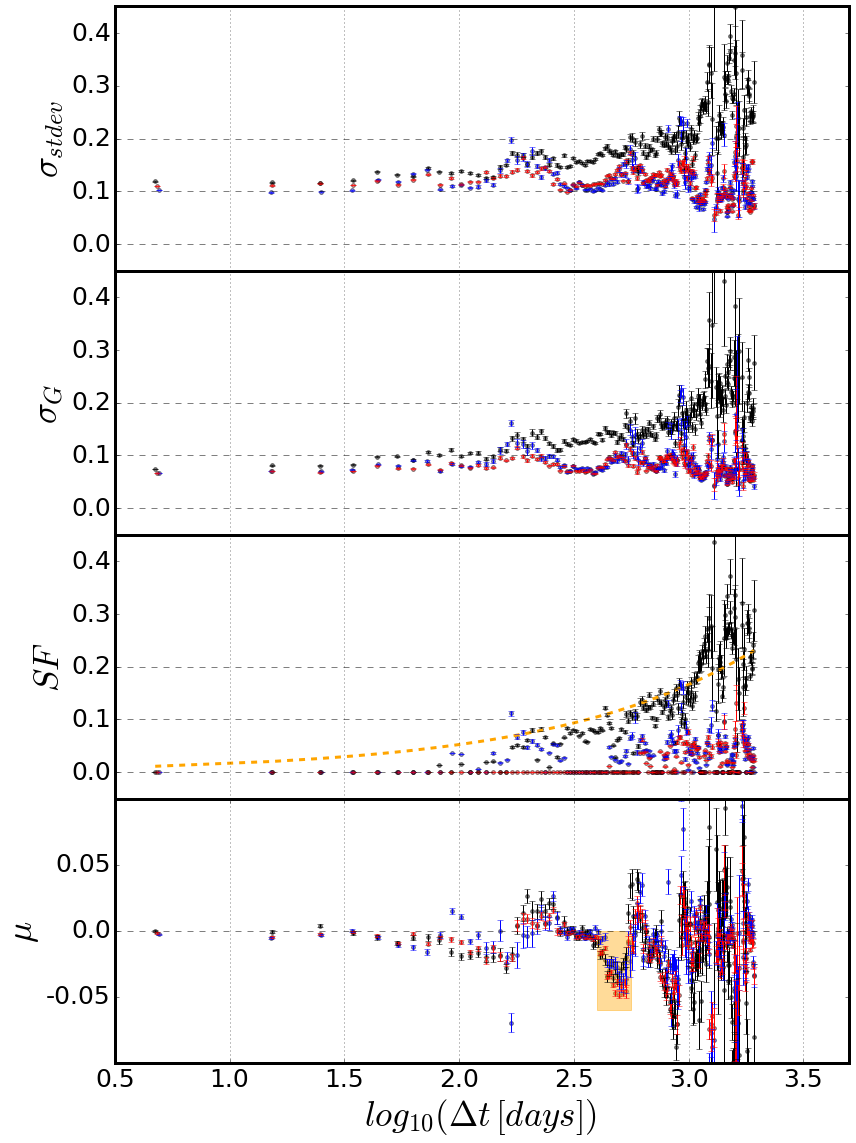

In [464]:
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit
%matplotlib inline
# set all plot parameters
lh_w   = 1.0  # horizontal line thickness 
lh_st  = '--' # horizontal line style 
lh_al  = 0.5  # horizontal line alpha parameter 

# dot size 
p_size = 14 # 7
p_al   = 0.5 

# y limits for sigma, sigma_G, SF panels 
y_top  = 0.45
y_bott = -0.05

# y limits for mu approx 
y_mu_top = 0.1
y_mu_bott = -0.1

# x limits for ALL PANELS 
x_left = 0.5
x_right = 3.7

# colors for quasars, blue and red stars 
colors= {}
colors['qso'] = 'black'
colors['starsB'] = 'blue'
colors['starsR']   = 'red'

fig,ax = plt.subplots(4,1, figsize=(12,16), sharex=True)


# Panel 1 
for obj in plot_data.keys() : 
    ax[0].scatter(np.log10(plot_data[obj]['meanTau']), plot_data[obj]['stdev'], s=p_size, 
                    alpha=p_al, c = colors[obj])
    errStdev = plot_data[obj]['stdev'] / np.sqrt(2.0*(plot_data[obj]['binCount'] - 1.0))
    ax[0].errorbar(np.log10(plot_data[obj]['meanTau']), plot_data[obj]['stdev'],errStdev, 
                   linestyle='None', c = colors[obj]  )

ax[0].set_ylabel(r'$\sigma_{stdev}$')   # ,fontsize=20 
ax[0].tick_params( axis='x', which='both',  bottom='off', 
                top='off', labelbottom='off') 
ax[0].set_ylim(bottom=y_bott, top=y_top)
ax[0].set_xlim(left=x_left, right=x_right)
ax[0].set_yticks([0,0.1,0.2,0.3,0.4])
ax[0].set_yticklabels(['0.0','0.1', '0.2', '0.3', '0.4'])
ax[0].axhline(y=0.0, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[0].axhline(y=0.1, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[0].axhline(y=0.2, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[0].grid(axis='x')



# Panel 2
for obj in plot_data.keys() : 
    ax[1].scatter(np.log10(plot_data[obj]['meanTau']), plot_data[obj]['sigmaG'], s=p_size, 
                    alpha=p_al, c = colors[obj])
    errSigmaG = plot_data[obj]['sigmaG']* 1.06 / np.sqrt(plot_data[obj]['binCount'])
    ax[1].errorbar(np.log10(plot_data[obj]['meanTau']), plot_data[obj]['sigmaG'],errSigmaG, 
                   linestyle='None', c = colors[obj] )


ax[1].set_ylabel(r'$\sigma_{G}$')   # ,fontsize=20 
ax[1].tick_params( axis='x', which='both',  bottom='off', 
                top='off', labelbottom='off') 
ax[1].set_ylim(bottom=y_bott, top=y_top)
ax[1].set_xlim(left=x_left, right=x_right)
ax[1].set_yticks([0,0.1,0.2,0.3,0.4])
ax[1].set_yticklabels(['0.0','0.1', '0.2', '0.3', '0.4'])
ax[1].axhline(y=0.0, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[1].axhline(y=0.1, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[1].axhline(y=0.2, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[1].grid(axis='x')




    # mu_bins['approx_err'] = bin_stdev / np.sqrt(bin_count)


# Panel 3
 
def model_sf(t, sf_inf=0.25, tau = 1.0):
    br = 1.0-np.exp(-t/tau)
    sf = sf_inf * np.power(br,0.5)
    return sf

# Calculate the model DRW fit for QSO
obj = 'qso'
xdata = plot_data[obj]['meanTau']
sf = plot_data[obj]['sigmaFull']
popt, pcov = curve_fit(model_sf, xdata, sf)
y = model_sf(xdata, sf_inf=popt[0], tau = popt[1]) # tau 1 year in days 

# Fold-in the error to the model SF , plot 
# both folded and not-folded version 

err_sig = plot_data[obj]['sigmaFull']* 1.06 / np.sqrt(plot_data[obj]['binCount'])
#y_fold = np.sqrt((y ** 2.0)+ (err_sig ** 2.0) )
#ax[2].plot(np.log10(xdata), y_fold , lw=3, c = 'green', ls='--')
ax[2].plot(np.log10(xdata), y , lw=3, c = 'orange', ls='--')

#text = r'$ \mathrm{Model:}\ \tau=%.3f \,\mathrm{days} , \ SF_{\infty}=%.3f \,\mathrm{mag}$'%(popt[1],popt[0])
#ax[2].text(x=0.75, y=0.3,s = text )


# plot approximate sigma 
for obj in plot_data.keys() : 
    
    ax[2].scatter(np.log10(plot_data[obj]['meanTau']), plot_data[obj]['sigmaFull'], s=p_size, 
                    alpha=p_al, c = colors[obj])
    err_sig = plot_data[obj]['sigmaFull']* 1.06 / np.sqrt(plot_data[obj]['binCount'])
    # 
    ax[2].errorbar(np.log10(plot_data[obj]['meanTau']), plot_data[obj]['sigmaFull'],err_sig, 
                   linestyle='None', c = colors[obj]  )
    
    
ax[2].set_ylim(bottom=y_bott, top=y_top)
ax[2].set_xlim(left=x_left, right=x_right)
ax[2].set_ylabel(r'$SF $') # ,fontsize=20 
ax[2].tick_params( axis='x', which='both',  bottom='off', 
                top='off', labelbottom='off')
ax[2].grid(axis='x')
ax[2].set_yticks([0,0.1,0.2,0.3,0.4])
ax[2].set_yticklabels(['0.0','0.1', '0.2', '0.3', '0.4'])
ax[2].axhline(y=0.0, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)    
ax[2].axhline(y=0.1, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[2].axhline(y=0.2, color='black', lw=lh_w, ls=lh_st,alpha=lh_al) 

# Panel 4 
for obj in plot_data.keys() : 
    ax[3].scatter(np.log10(plot_data[obj]['meanTau']), plot_data[obj]['muFull'], s=p_size, 
                    alpha=p_al, c = colors[obj])
    err_mu =  plot_data[obj]['stdev'] / np.sqrt(plot_data[obj]['binCount'])
    ax[3].errorbar(np.log10(plot_data[obj]['meanTau']), plot_data[obj]['muFull'],err_mu, 
                   linestyle='None', c = colors[obj]  )
    
ax[3].axhline(y=0.0, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[3].set_ylim(top=y_mu_top, bottom=y_mu_bott)
ax[3].set_xlim(left=x_left, right=x_right)
ax[3].set_yticks([-0.05,0,0.05])
ax[3].set_yticklabels(['-0.05','0.0', '0.05'])  
ax[3].set_ylabel(r'$\mu$') #  ax[3].set_ylabel(r'$\mu$') # 


ax[3].grid(axis='x')
# r'$log_{10} (\Delta t $'+ '[days]' +r'$)$ '
ax[3].set_xlabel(r'$log_{10} (\Delta t \, [days] )$ ') # ,fontsize=20

vline_color = 'orange'
#vline_lw = 2 
#ax[3].axvline(2.6, ymax=0.5, color=vline_color, lw=vline_lw, ls='--')
#ax[3].axvline(2.75, ymax=0.5, color=vline_color,lw=vline_lw, ls='--')
ax[3].fill_between([2.6, 2.75], y1=-0.06, y2=0, color='orange', alpha=0.4)
figname = outDir+'Fig_2_'+str(Min)+'-'+str(Max)+'_PTF_panels.png'
plt.tight_layout()
fig.subplots_adjust(hspace=0)
plt.savefig(figname)
print('Figure is saved as %s'% figname )

# 

Plot the histogram of $\Delta m_{ij}$ for points that have surprisingly low mean ...

In [482]:
rcParams['ytick.labelsize'] = 20
rcParams['xtick.labelsize'] = 20
rcParams['axes.labelsize'] = 25
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 20

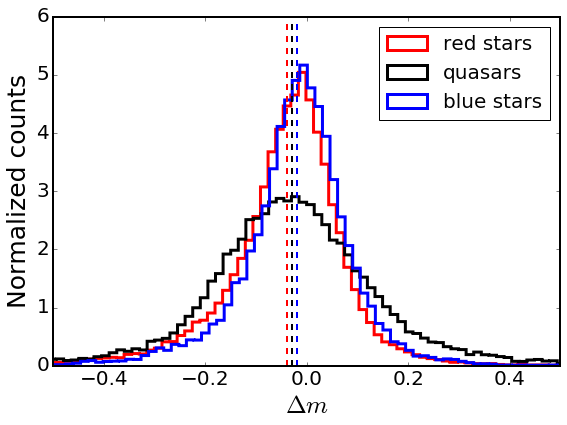

In [486]:
import matplotlib 
#matplotlib.rc('xtick', labelsize=15) 
#matplotlib.rc('ytick', labelsize=15) 

fig,ax = plt.subplots(figsize=(8,6))

xmax = 0.5
xmin = -xmax

colors = {'qso':'black', 'starsB':'blue', 'starsR':'red'}
labels  = {'qso':'quasars', 'starsB':'blue stars', 'starsR':'red stars'}
b = 'r_cut'
for obj in out_dic[b].keys() : 
    m_ij = out_dic[b][obj][0]
    tau = out_dic[b][obj][1]

    # remove outliers , in the same way as for the plot above 
    m1  = abs(m_ij) < 1.0

    # choose the right timescale 
    tau1 = np.power(10,2.6)
    tau2 = np.power(10,2.75)
    m2 =  (tau1 < tau)*(tau <tau2)
    
    # select only to plot those within the axis bounds
    m3 = abs(m_ij) < 0.6 
    
    # combine masks together 
    m = m1*m2*m3
    
    # plot the histogram
    ax.hist(m_ij[m], histtype='step', bins=80, label=labels[obj], normed=True, lw=3, color=colors[obj])
    
    # vertical lines
    ax.axvline(np.mean(m_ij[m]), ls='--', color = colors[obj] , lw=2)

ax.set_xlabel(r'$\Delta m$') # , fontsize=20
ax.set_ylabel('Normalized counts') # , fontsize=20 
ax.set_xlim(xmin, xmax)
#ax.set_title(r'$ %.2f< \Delta t < %.2f $  [days] '%(tau1, tau2), ) # , fontsize = 20  
plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig(outDir +'Fig_2_'+str(Min)+'-'+str(Max)+'_log_2.6-2.75_hist.png' )

